In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:

# Load the data
file_path = f"../data/PRISMA_ICA.csv"
data = pd.read_csv(file_path, delimiter=";")
band_names = data.columns[:3].tolist()
target_column = data.columns[-1]
data.columns = band_names + [target_column]

# Create features and target
X = data.drop('class', axis=1)
y = data['class']

# Convert labels into binary values
y[y == 'alteration'] = 0
y[y == 'host rock'] = 1
y = y.astype(int)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)

In [3]:
# Normalize the data between 0 and 1 using only the training data
scaler = MinMaxScaler()
X_train[band_names] = scaler.fit_transform(X_train[band_names])
X_test[band_names] = scaler.transform(X_test[band_names])

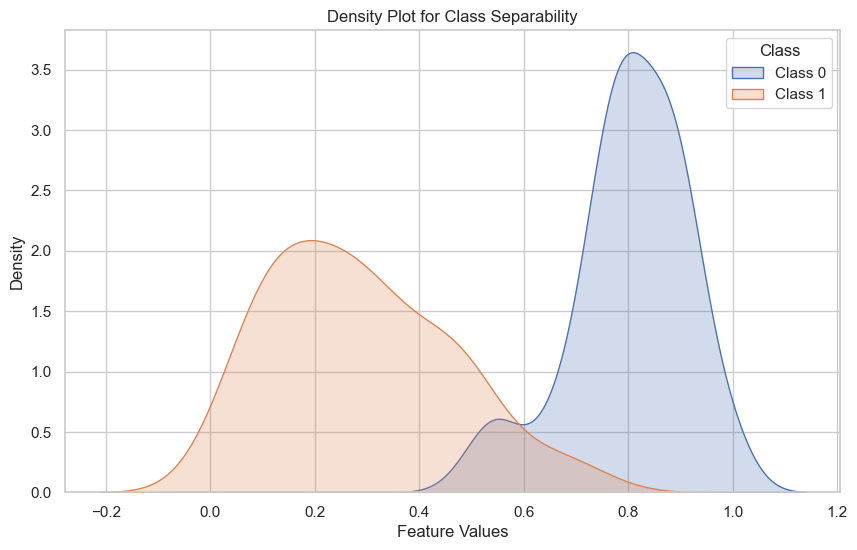

In [4]:
# SVC classifier for Class separability Verification
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Generate predictions
y_pred = classifier.predict(X_test)

# Plot Density Graphs
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
for label in np.unique(y):
    sns.kdeplot(X_test.loc[y_test == label, 'PC1'], label=f'Class {label}', shade=True)
plt.title('Density Plot for Class Separability')
plt.xlabel('Feature Values')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()

In [5]:
# Dummy Classifier
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train)
dummy_score = dummy_clf.score(X_test, y_test)
print(f"Dummy Classifier Accuracy: {dummy_score:.2f}")


Dummy Classifier Accuracy: 0.48


In [6]:
# SVM classifier
param_grid_svm = {'C': [0.001, 0.025, 0.05, 0.25, 0.5, 1, 2, 14, 20, 35],
                  'gamma': [0.0005, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 2, 5, 8]}
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, n_jobs=-1, verbose=1, scoring='accuracy', return_train_score=True)
grid_search_svm.fit(X_train, y_train)
svm_clf = SVC(C=grid_search_svm.best_estimator_.get_params()['C'], 
              gamma=grid_search_svm.best_estimator_.get_params()['gamma'], 
              probability=True)
svm_clf.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


SVC(C=1, gamma=1, probability=True)

In [7]:
# View best hyperparameters
print('Best C:', grid_search_svm.best_estimator_.get_params()['C'])
print('Best gamma:', grid_search_svm.best_estimator_.get_params()['gamma'])

# Show best cross-validation accuracy
print("Best cross-validation accuracy: {:.2f}".format(grid_search_svm.best_score_))

# Access the model with the best parameters
grid_search_svm.best_params_

Best C: 1
Best gamma: 1
Best cross-validation accuracy: 0.98


{'C': 1, 'gamma': 1}

In [8]:
# Random Forest classifier
param_grid_rf = {'n_estimators': [50, 100, 150],
                 'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1, verbose=1, scoring='accuracy', return_train_score=True)
grid_search_rf.fit(X_train, y_train)
rf_clf = RandomForestClassifier(**grid_search_rf.best_params_)
rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


RandomForestClassifier(min_samples_split=5, n_estimators=50)

In [9]:
# View best hyperparameters
print('Best max_depth:',  grid_search_rf.best_estimator_.get_params()['max_depth'])
print('min_samples_split:', grid_search_rf.best_estimator_.get_params()['min_samples_split'])
print('min_samples_leaf:', grid_search_rf.best_estimator_.get_params()['min_samples_leaf'])
print('n_estimators:', grid_search_rf.best_estimator_.get_params()['n_estimators'])
# show best cross-validation accuracy
print("Best cross-validation accuracy: {:.2f}".format(grid_search_rf.best_score_))

# access the model with the best parameters
grid_search_rf.best_params_

Best max_depth: None
min_samples_split: 5
min_samples_leaf: 1
n_estimators: 50
Best cross-validation accuracy: 0.98


{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [10]:
# ANN classifier
param_grid_ann = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                  'activation': ['tanh', 'relu'],
                  'solver': ['sgd', 'adam'],
                  'alpha': [0.0001, 0.05],
                  'learning_rate': ['constant','adaptive']}
grid_search_ann = GridSearchCV(MLPClassifier(), param_grid_ann, cv=5, n_jobs=-1, verbose=1, scoring='accuracy', return_train_score=True)
grid_search_ann.fit(X_train, y_train)
ann_clf = MLPClassifier(**grid_search_ann.best_params_)
ann_clf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


MLPClassifier(activation='tanh')

In [12]:
# View best hyperparameters
print('hidden_layer_sizes:', grid_search_ann.best_estimator_.get_params()['hidden_layer_sizes'])
print('activation:', grid_search_ann.best_estimator_.get_params()['activation'])
print('solver:', grid_search_ann.best_estimator_.get_params()['solver'])
print('alpha:', grid_search_ann.best_estimator_.get_params()['alpha'])
print('learning_rate:', grid_search_ann.best_estimator_.get_params()['learning_rate'])

# Show best cross-validation accuracy
print("Best cross-validation accuracy: {:.2f}".format(grid_search_ann.best_score_))

# Access the model with the best parameters
grid_search_ann.best_params_

hidden_layer_sizes: (100,)
activation: tanh
solver: adam
alpha: 0.0001
learning_rate: constant
Best cross-validation accuracy: 0.98


{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [14]:
# Soft Voting Classifier with SVM, Random Forest, and ANN
voting_clf = VotingClassifier(
    estimators=[('svm', svm_clf), ('rf', rf_clf), ('ann', ann_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svm', SVC(C=1, gamma=1, probability=True)),
                             ('rf',
                              RandomForestClassifier(min_samples_split=5,
                                                     n_estimators=50)),
                             ('ann', MLPClassifier(activation='tanh'))],
                 voting='soft')

In [15]:
svm_score = svm_clf.score(X_test, y_test)
print(f"SVM Classifier Accuracy: {svm_score:.2f}")
ann_score = ann_clf.score(X_test, y_test)
print(f"ANN Classifier Accuracy: {ann_score:.2f}")
rf_score = rf_clf.score(X_test, y_test)
print(f"Random Forest Classifier Accuracy: {rf_score:.2f}")
voting_score = voting_clf.score(X_test, y_test)
print(f"Soft Voting Classifier Accuracy: {voting_score:.2f}")

SVM Classifier Accuracy: 0.98
ANN Classifier Accuracy: 0.98
Random Forest Classifier Accuracy: 0.99
Soft Voting Classifier Accuracy: 0.99



SVM Classifier:
Accuracy: 0.98
Precision: 1.00
Recall: 0.97
F1 Score: 0.98
ROC AUC: 1.00


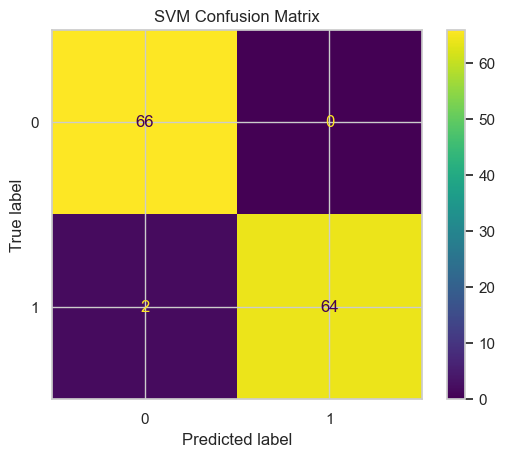


Random Forest Classifier:
Accuracy: 0.99
Precision: 1.00
Recall: 0.98
F1 Score: 0.99
ROC AUC: 1.00


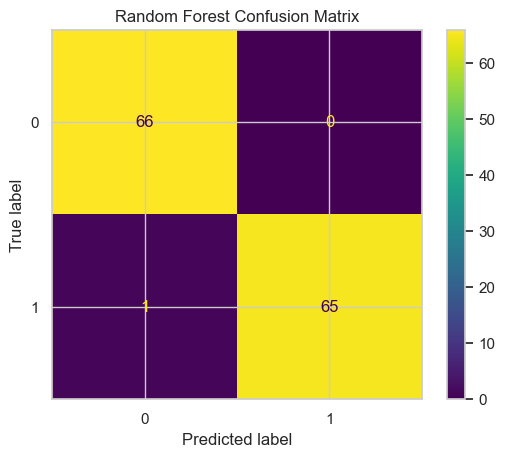


ANN Classifier:
Accuracy: 0.98
Precision: 1.00
Recall: 0.97
F1 Score: 0.98
ROC AUC: 1.00


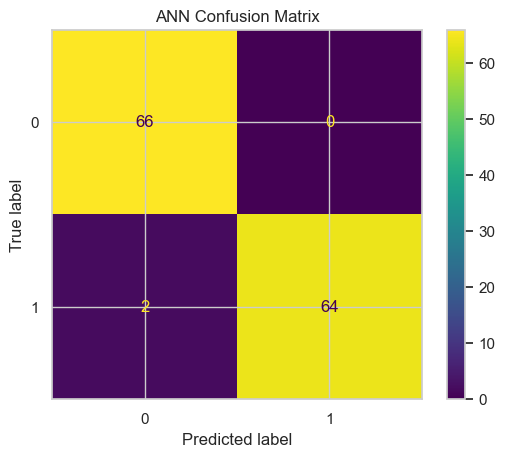


Voting Classifier:
Accuracy: 0.99
Precision: 1.00
Recall: 0.98
F1 Score: 0.99
ROC AUC: 1.00


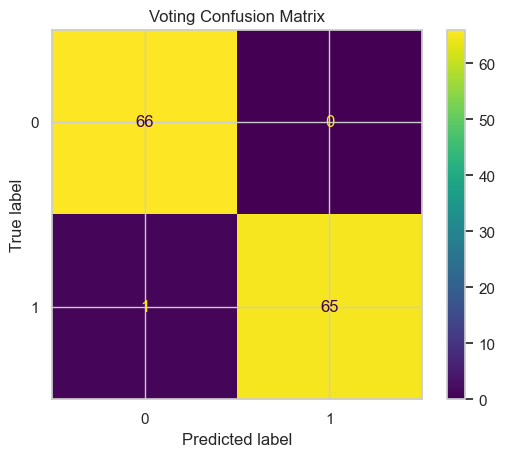

In [16]:
# Metrics calculation
models = {'SVM': svm_clf, 'Random Forest': rf_clf, 'ANN': ann_clf, 'Voting': voting_clf}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Classifier:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"ROC AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f}")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# Predictions 

In [17]:
import numpy as np
import pandas as pd
import rasterio as rio
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [20]:
# Load the bands 
##The band inputs are expected to be a result of the same dimensionality reduction techinique
b4 = rio.open(r"C:\Users\mrgnc\Workspace\PRISMA\images\ICA_result\ICA_PC1.tif")
b6 = rio.open(r"C:\Users\mrgnc\Workspace\PRISMA\images\ICA_result\ICA_PC2.tif")
b7 = rio.open(r"C:\Users\mrgnc\Workspace\PRISMA\images\ICA_result\ICA_PC3.tif")

B4 = b4.read(1).astype('float32')
B6 = b6.read(1).astype('float32')
B7 = b7.read(1).astype('float32')

# Normalize the bands
def min_max_normalize(band):
    min_val = np.min(band)
    max_val = np.max(band)
    return (band - min_val) / (max_val - min_val)

B4_normalized = min_max_normalize(B4)
B6_normalized = min_max_normalize(B6)
B7_normalized = min_max_normalize(B7)

# Truncate and stack bands
min_length = min(B4_normalized.shape[0], B6_normalized.shape[0], B7_normalized.shape[0])
B4_truncated = B4_normalized[:min_length]
B6_truncated = B6_normalized[:min_length]
B7_truncated = B7_normalized[:min_length]
reshaped_img = np.dstack([B4_truncated, B6_truncated, B7_truncated])

# Predict image probabilities using the soft voting classifier
class_probabilities = voting_clf.predict_proba(reshaped_img.reshape(-1, 3))

# Select the class with the highest probability for each pixel
class_prediction = np.argmax(class_probabilities, axis=1)

# Reshape the image back into a 2D matrix
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

# Convert the class indices to the original string labels
class_labels = {0: 'alteration', 1: 'host rock'}
class_prediction = np.vectorize(class_labels.get)(class_prediction)

# Convert the classes' string labels to integer values
class_labels = {'alteration': 1, 'host rock': 2}
class_prediction = np.vectorize(class_labels.get)(class_prediction)

# Save the final image to a GeoTIFF file with integer data type
output_path = r"C:\Users\mrgnc\Workspace\PRISMA\images\results_ensemble.tif"
with rio.open(output_path, 'w', driver='Gtiff', width=b4.width, height=b4.height, count=1, crs=b4.crs, transform=b4.transform, dtype='int32') as dst:
    dst.write(class_prediction.astype('int32'), 1)